# Семинар 11. Нейронные сети

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
\DeclareMathOperator{\TP}{TP}
\DeclareMathOperator{\FP}{FP}
\DeclareMathOperator{\TN}{TN}
\DeclareMathOperator{\FN}{FN}
\DeclareMathOperator{\Accuracy}{Accuracy}
\DeclareMathOperator{\Precision}{Precision}
\DeclareMathOperator{\Recall}{Recall}
\DeclareMathOperator{\Fscore}{F_1}
\DeclareMathOperator{\MSE}{MSE}
\DeclareMathOperator{\RMSE}{RMSE}
\DeclareMathOperator{\MAE}{MAE}
\DeclareMathOperator{\MAPE}{MAPE}
\DeclareMathOperator{\Rsqured}{R^2}
$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

cm_bright = ListedColormap(['red', 'blue'])
cm = plt.cm.get_cmap('RdBu')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 4)

In [2]:
from sklearn import set_config

set_config(display='diagram')

In [3]:
import tensorflow as tf

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

Для наблюдения за процессом обучения:

In [3]:
from tqdm.auto import tqdm
from tensorflow.keras.callbacks import Callback


class ProgressCallback(Callback):
    def __init__(self, epochs):
        self.pbar = tqdm(total=epochs)

    def on_epoch_end(self, epoch, logs):
        if epoch % 128 == 0 or epoch >= self.pbar.total - 1:
            self.pbar.update(max(0, epoch - self.pbar.n))
            self.pbar.refresh()

Метрики в задаче регрессии:

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def regression_metrics(true, pred, verbose=False, plot=False):
    mae = mean_absolute_error(true, pred)
    mape = np.abs((true - pred) / true).mean()
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)
    return dict(zip(
        ['mae', 'mse', 'rmse', 'mape', 'r2'],
        [mae, mse, rmse, mape, r2]
    ))

Для демонстрации задачи классификации:

In [5]:
def plot_classification(X, y, model):
    pred = (model.predict(X).squeeze() > 0.5).astype(int)
    
    idx = (y == pred) & (y == 1)
    plt.scatter(X[idx, 0], X[idx, 1], color='blue', label='true=1, pred=1')

    idx = (y != pred) & (y == 1)
    plt.scatter(X[idx, 0], X[idx, 1], color='cyan', label='true=1, pred=0')

    idx = (y == pred) & (y == 0)
    plt.scatter(X[idx, 0], X[idx, 1], color='red', label='true=0, pred=0')

    idx = (y != pred) & (y == 0)
    plt.scatter(X[idx, 0], X[idx, 1], color='yellow', label='true=0, pred=1')

def plot_decision_map(X, y, model, proba=False):
    X1, X2 = X[:, 0], X[:, 1]
    
    x1_low, x1_high = X1.min(), X1.max()
    x2_low, x2_high = X2.min(), X2.max()
    d1, d2 = x1_high - x1_low, x2_high - x2_low
    
    x1_low -= d1 * 0.1
    x2_low -= d2 * 0.1
    x1_high += d1 * 0.1
    x2_high += d2 * 0.1
    
    
    X1 = np.linspace(x1_low, x1_high, 128)
    X2 = np.linspace(x2_low, x2_high, 128)
    X1, X2 = np.meshgrid(X1, X2)
    Z = np.c_[X1.flatten(), X2.flatten()]
    
    Z = model.predict(Z).squeeze()
    if not proba:
        Z = (Z > 0.5).astype(int)
    Z = Z.reshape(X1.shape)

    cmap = cm if proba else cm_bright
    plt.contourf(X1, X2, Z, cmap=cmap, alpha=0.2)
    
def plot_all(X, y, model, proba=False, title=''):
    plt.figure(0, (12, 8))
    plot_classification(X, y, model)
    plot_decision_map(X, y, model, proba=proba)
    
    plt.title(title)
    plt.legend()

# 1. Нейронные сети на Keras в задаче регрессии

In [6]:
from scipy.integrate import simps


def integrated_squared_error(y_true, y_pred, x):
    return simps(np.power(y_true - y_pred, 2), x)

In [7]:
def plot_results(model):
    x_plt = np.linspace(low, high, 1024)
    y_plt = model.predict(x_plt.reshape(-1, 1)).squeeze()
    error = integrated_squared_error(gt_func(x_plt), y_plt, x_plt)

    plt.scatter(X, y, color='blue', alpha=0.6)
    plt.axhline(0, color='black', alpha=0.5)
    plt.plot(x_plt, y_plt, ls='--', color='blue')
    plt.plot(x_plt, gt_func(x_plt), ls='--', color='green')
    plt.title(f'Error: {error:.5f}')
    plt.show()

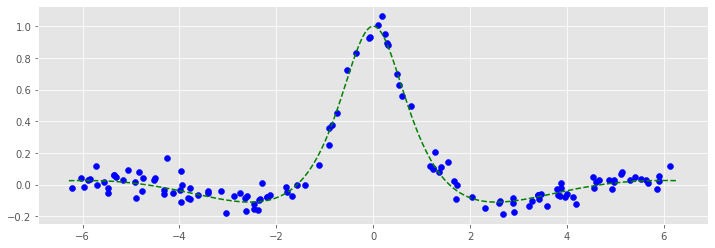

In [9]:
def gt_func(x):
    return np.cos(x) / (np.power(x, 2) + 1)

N = 128
noise_std = 0.05
low, high = -2 * np.pi, 2 * np.pi

np.random.seed(42)
X = np.random.uniform(low, high, N).reshape(-1, 1)
y = gt_func(X[:, 0]) + np.random.normal(scale=noise_std, size=N)

x_plt = np.linspace(low, high, 8192)
plt.scatter(X, y, color='blue')
plt.plot(x_plt, gt_func(x_plt), ls='--', color='green')
plt.show()

SVR(C=116.01553017399715, gamma=0.9641108804907496)

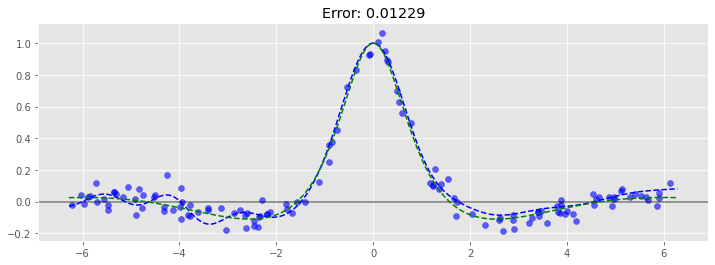

CPU times: user 3.69 s, sys: 157 ms, total: 3.85 s
Wall time: 11.7 s


In [11]:
%%time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = SVR()
model = GridSearchCV(svr, {
    'C': np.logspace(-2, 4, 32),
    'gamma': np.logspace(-2, 3, 64)
}, n_jobs=-1)
model.fit(X, y)
display(model.best_estimator_)
plot_results(model)

## 1.1. Пример на синтетических данных

In [13]:
import tensorflow as tf
import tensorflow.keras as K

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Обучаем модель:

In [45]:
model = Sequential([
    Dense(128, activation='relu', input_dim=1),
    Dense(16, activation='relu'),
    Dense(1),
], name='seq')

In [46]:
optimizer = Adam(learning_rate=0.001)

In [47]:
model.compile(optimizer, loss='mse', run_eagerly=False)

In [48]:
X.shape

(128, 1)

In [49]:
y.shape

(128,)

In [50]:
epochs = 512


fit_history = model.fit(X, y, 
    batch_size=128,
    validation_split=0.1, 
    validation_freq=1, 
    epochs=epochs, 
    verbose=0,
    callbacks=[
        ProgressCallback(epochs)
    ]
)

  0%|          | 0/512 [00:00<?, ?it/s]

In [51]:
model.summary()

Model: "seq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________


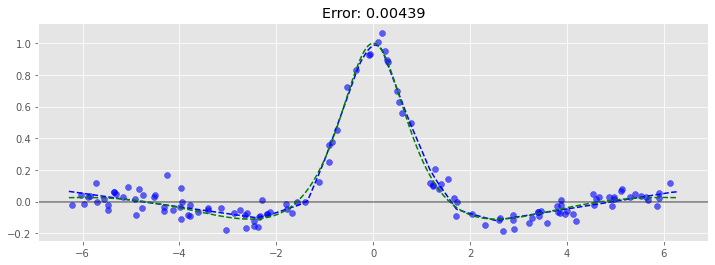

In [52]:
plot_results(model)

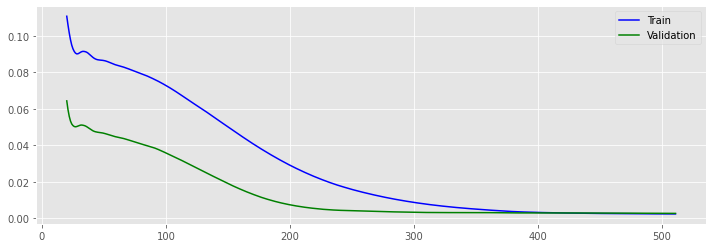

In [54]:
idx = np.arange(epochs)
start = 20

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')
plt.legend()
plt.show()

Добавляем регуляризацию:

  0%|          | 0/1024 [00:00<?, ?it/s]

Model: "seq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________


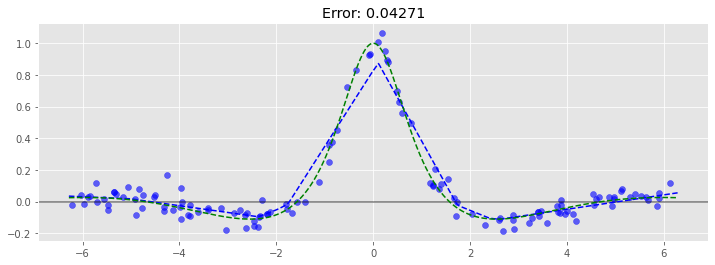

CPU times: user 1min 4s, sys: 3.77 s, total: 1min 8s
Wall time: 1min 38s


In [55]:
%%time
from tensorflow.keras.regularizers import l2


epochs = 1024
alpha = 1e-2

# Модель
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(alpha), input_dim=1),
    Dense(16, activation='relu', kernel_regularizer=l2(alpha)),
    Dense(1),
], name='seq')
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer, loss='mse', run_eagerly=False)

# обучение
fit_history = model.fit(X, y, 
    batch_size=128, 
    validation_split=0.1, 
    validation_freq=1, 
    epochs=epochs, 
    verbose=0,
    callbacks=[
        ProgressCallback(epochs)
    ]
)

model.summary()
plot_results(model)

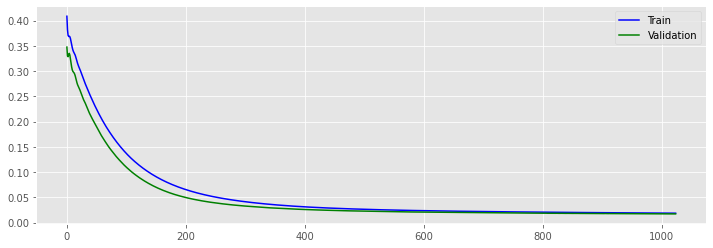

In [58]:
idx = np.arange(epochs)
start = 0

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')
plt.legend()
plt.show()

Уменьшаем learning_rate при выходе на плато:

  0%|          | 0/2048 [00:00<?, ?it/s]


Epoch 00666: ReduceLROnPlateau reducing learning rate to 0.00024999999441206456.

Epoch 01209: ReduceLROnPlateau reducing learning rate to 2.4999998277053238e-05.

Epoch 01752: ReduceLROnPlateau reducing learning rate to 1e-05.
Model: "seq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________


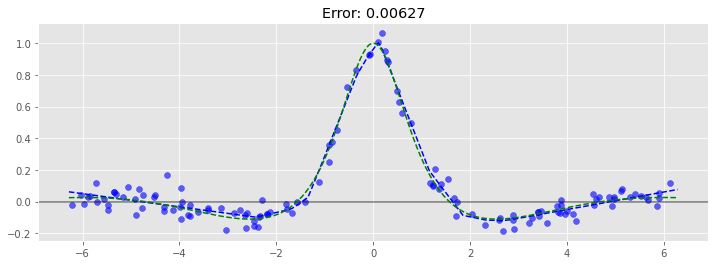

CPU times: user 1min 20s, sys: 3.07 s, total: 1min 23s
Wall time: 1min 22s


In [16]:
%%time
from tensorflow.keras.callbacks import ReduceLROnPlateau


epochs = 2048
alpha = 1e-3

# Модель
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(alpha), input_dim=1),
    Dense(16, activation='relu', kernel_regularizer=l2(alpha)),
    Dense(1),
], name='seq')
optimizer = Adam(learning_rate=0.0025)
model.compile(optimizer, loss='mse', run_eagerly=False)

# обучение
fit_history = model.fit(X, y, 
    batch_size=128, 
    validation_split=0.1, 
    validation_freq=1, 
    epochs=epochs, 
    verbose=0,
    callbacks=[
        ProgressCallback(epochs),
        ReduceLROnPlateau(patience=32, min_lr=1e-5, cooldown=512, verbose=1)
    ]
)

model.summary()
plot_results(model)

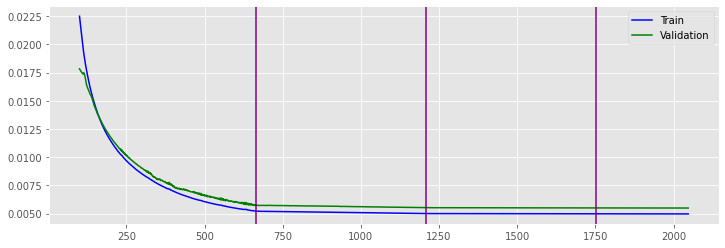

In [17]:
idx = np.arange(epochs)
start = 100

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')

lr = fit_history.history['lr']
for i in range(1, len(lr)):
    if ~np.isclose(lr[i - 1], lr[i]):
        plt.axvline(i, color='purple')
plt.legend()
plt.show()

## 1.2. Пример: расход топлива


Датасет __mpg__. По характеристикам машины необходимо спрогнозировать расход топлива.

Признаки:
* cylinders -- число цилиндров в двигателе;
* displacement -- рабочий объем, л;
* horsepower -- мощность, л.с.;
* weight -- вес, т;
* acceleration -- ускорение;
* model_year -- год выпуска модели;
* origin -- производитель;
* name -- название.

Целевая переменная:
* mpg -- миль на галлон, переведено в км/л.

In [60]:
frame = sns.load_dataset('mpg')
frame.dropna(inplace=True)

frame['displacement'] *= 16.3871 / 1000
frame['mpg'] = 100 / (frame.mpg * 1.60934 / 3.78541)
frame['weight'] *= 0.453592 / 1000

frame.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,13.067503,8,5.030840,130.0,1.589386,12.0,70,usa,chevrolet chevelle malibu
1,15.681004,8,5.735485,165.0,1.675115,11.5,70,usa,buick skylark 320
2,13.067503,8,5.211098,150.0,1.558542,11.0,70,usa,plymouth satellite
3,14.700941,8,4.981678,150.0,1.557181,12.0,70,usa,amc rebel sst
4,13.836180,8,4.948904,140.0,1.564439,10.5,70,usa,ford torino


In [62]:
X = frame.drop(columns=['mpg', 'name']).copy()
y = frame.mpg.copy()

Делим набор данных на привычные fit, test:

In [63]:
from sklearn.model_selection import train_test_split


X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Fit size:', X_fit.shape[0])
print('Test size:', X_test.shape[0])

Fit size: 313
Test size: 79


Отмасштабируем и закодируем признаки:

In [65]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


num_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year']
cat_features = ['origin']

transformer = make_column_transformer((StandardScaler(), num_features), 
                                      (OneHotEncoder(drop='first'), cat_features))
Xs_fit = transformer.fit_transform(X_fit)
Xs_test = transformer.transform(X_test)

In [74]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [76]:
%%time
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD


epochs = 1024
alpha=1e-3


# Модель
model = Sequential([
    Dense(32, kernel_regularizer=l2(alpha), bias_regularizer=l2(alpha), input_dim=Xs_fit.shape[1]),
    Dropout(0.2),
    ReLU(),
    Dense(1),
], name='seq')
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer, loss='mse', run_eagerly=False, steps_per_execution=10)

# обучение
fit_history = model.fit(Xs_fit, y_fit, 
    batch_size=64, 
    validation_split=0.1, 
    validation_freq=1, 
    epochs=epochs, 
    verbose=0,
    callbacks=[
        ProgressCallback(epochs),
        LearningRateScheduler(lambda epoch, lr: lr / 10 if epoch == 350 else lr, verbose=0)
    ]
)

model.summary()

  0%|          | 0/1024 [00:00<?, ?it/s]

Model: "seq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 32)                288       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
re_lu_2 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1min 9s, sys: 4.03 s, total: 1min 13s
Wall time: 1min 44s


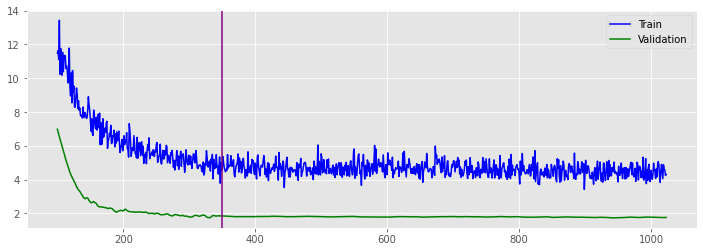

In [77]:
idx = np.arange(epochs)
start = 100

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')

if 'lr' in fit_history.history:
    lr = fit_history.history['lr']
    for i in range(1, len(lr)):
        if ~np.isclose(lr[i - 1], lr[i]):
            plt.axvline(i, color='purple')

plt.legend()
plt.show()

In [78]:
regression_metrics(y_test, model.predict(Xs_test).squeeze(), verbose=True)

{'mae': 1.1165746802331618,
 'mse': 2.0267332998363474,
 'rmse': 1.4236338362923058,
 'mape': 0.10291078044608858,
 'r2': 0.8570686737554256}

## 1.3. Keras и GridSearch

Модели в Keras не удовлетворяют требованиям Sklearn.
Для совместного использования с Pipeline и GridSearchCV нужно "обернуть" модель в специальный объект: 

In [80]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


def build_model(lr, n_hidden, dropout):
    # Модель
    model = Sequential()
    model.add(Dense(n_hidden, input_dim=8))
    model.add(Dropout(dropout))
    model.add(ReLU())
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer, loss='mse', run_eagerly=False)
    return model

net = KerasRegressor(build_model)

In [81]:
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
    ('transform', transformer),
    ('net', net)
])
pipeline

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('net',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x1946d5e50>)])

In [27]:
%%time
from sklearn.model_selection import GridSearchCV, KFold


param_grid = {
    'net__lr': [1e-3],
    'net__dropout': [0.1, 0.2, 0.3],
    'net__n_hidden': [32, 64, 128],
    'net__epochs': [1536], 
    'net__batch_size': [64], 
    'net__verbose': [0]
}

gs = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose=51,
                  cv=KFold(10, shuffle=True, random_state=42),
                  scoring='neg_mean_squared_error')
gs.fit(X_fit, y_fit)
gs.best_params_

Fitting 10 folds for each of 9 candidates, totalling 90 fits
CPU times: user 7.5 s, sys: 551 ms, total: 8.05 s
Wall time: 2min 41s


{'net__batch_size': 64,
 'net__dropout': 0.2,
 'net__epochs': 1536,
 'net__lr': 0.001,
 'net__n_hidden': 128,
 'net__verbose': 0}

In [28]:
regression_metrics(y_test, gs.predict(X_test).squeeze(), verbose=True)

{'mae': 0.8487207079128442,
 'mse': 1.301665510098817,
 'rmse': 1.1409055658111311,
 'mape': 0.08072494937180082,
 'r2': 0.9082026344066744}

# 2. Нейронные сети на Keras в задаче классификации

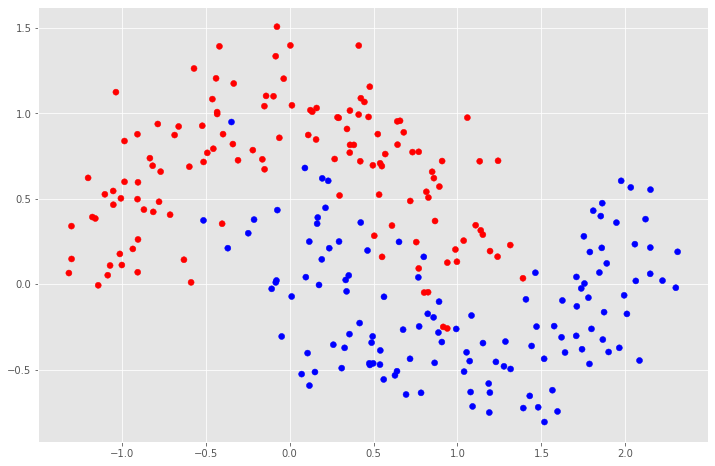

In [82]:
from sklearn.datasets import make_moons


X, y = make_moons(n_samples=256, 
                  shuffle=True,
                  noise=0.2,
                  random_state=42)

plt.figure(0, (12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
plt.show()

In [84]:
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, mae, mse

  0%|          | 0/512 [00:00<?, ?it/s]

Model: "seq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 16)                48        
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_4 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 5         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
CPU times: user 35.9 s, sys: 2.4 s, total: 38.3 s
Wall time: 55.5 s


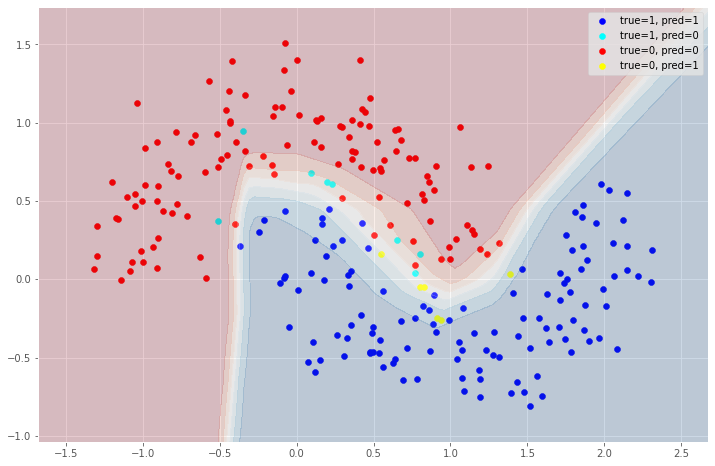

In [85]:
%%time
epochs = 512

# Модель
model = Sequential([
    Dense(16, activation='relu', input_dim=2),
    Dropout(0.1),
    Dense(4, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid'),
], name='seq')
optimizer = Adam(learning_rate=0.003)
model.compile(optimizer, loss='binary_crossentropy')

# обучение
fit_history = model.fit(X, y, 
    batch_size=128, 
    validation_split=0.1, 
    validation_freq=1, 
    epochs=epochs, 
    verbose=0,
    callbacks=[
        ProgressCallback(epochs)
    ]
)

model.summary()
plot_all(X, y, model, proba=True)

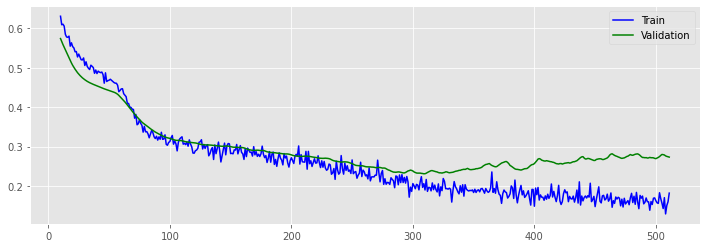

In [86]:
idx = np.arange(epochs)
start = 10

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')

plt.legend()
plt.show()

Круги:

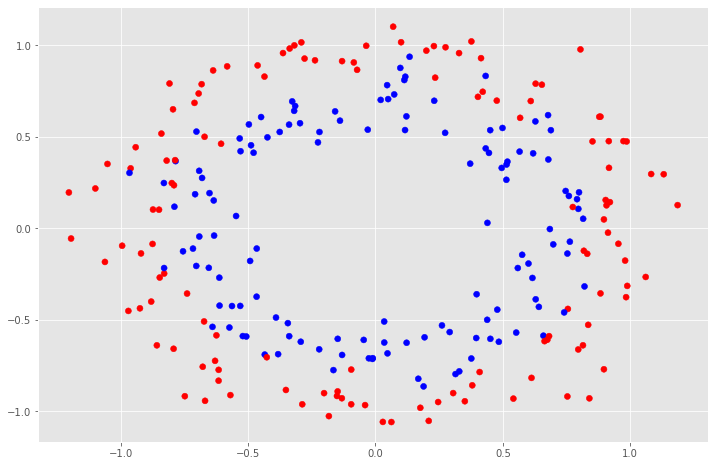

In [87]:
from sklearn.datasets import make_circles


X, y = make_circles(n_samples=256, 
                  shuffle=True,
                  noise=0.1, factor=0.7,
                  random_state=42)

plt.figure(0, (12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]

Model: "seq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                48        
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_8 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 5         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
CPU times: user 21.1 s, sys: 1.35 s, total: 22.4 s
Wall time: 32.2 s


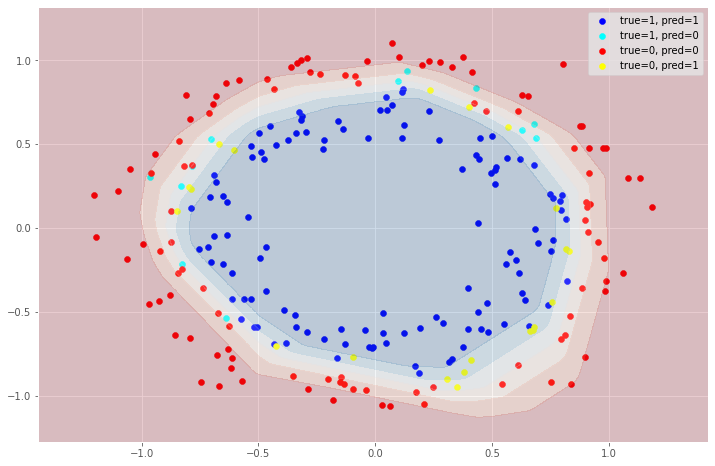

In [92]:
%%time
epochs = 300

# Модель
model = Sequential([
    Dense(16, activation='relu', input_dim=2),
    Dropout(0.2),
    Dense(4, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
], name='seq')
optimizer = Adam(learning_rate=0.0025)
model.compile(optimizer, loss='binary_crossentropy', run_eagerly=False, steps_per_execution=10)

# обучение
fit_history = model.fit(X, y, 
    batch_size=128, 
    validation_split=0.1, 
    validation_freq=1, 
    epochs=epochs, 
    verbose=0,
    callbacks=[
        ProgressCallback(epochs)
    ]
)

model.summary()
plot_all(X, y, model, proba=True)

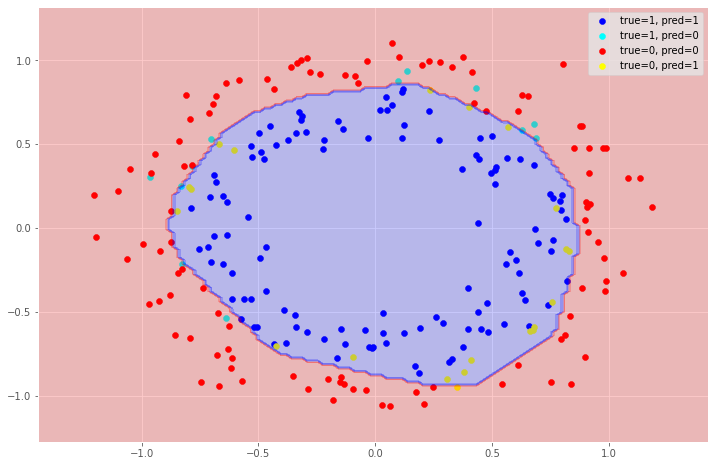

In [95]:
plot_all(X, y, model, proba=False)

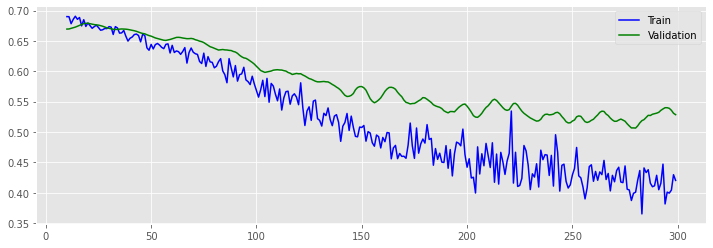

In [96]:
idx = np.arange(epochs)
start = 10

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')

plt.legend()
plt.show()